# Union of the Sources
Search for the MOT by unifying the key data sources in single timeseries. 

## Overview

### Problem
When we look at the data sources like the SSD or the CMOS images separately, then we find many promising hints for the MOT signal, but we cannot know if it is really the Francium MOT signal. Reconstructing each potential signal with the other data would be too time consuming. 


### Idea
We slice the time into intervals and display all relevant sources in a single timeseries plot. When we see a potential Fr MOT signal, then we can directly cross-check the other signals for verification. 

### Relevant sources
We will consider the following sources: 
- Neutralizer heater
- SSD1
- SSD2
- MOT coil
- CMOS images
- Wavemeter
- Linear manipulator position (if available)


## Data sources
As the amount of data is 1) big for pandas 2) distributed across many files, we have to find a schema on how to process the data. For this, we consider how the data from each source is distributed accross files. 

### Heater
The heater log of the neutralizer heater is stored as one file per day. It contains a timestamp, a duration, a voltage and a power. In theory, we can just mark the heating as a vertical line at the timestamp. We can use the heater information to query the data: If there is no heating, the data is not interesting. 

### SSD1 and SSD2
The SSD data is distributed across many files of varying size, each covering one of the non-overlapping timespans. In the SSDAnalysis we combine these files, convert the pulses into a pulse rate, and finds the peaks. In a first step, it would be possible to just work with these peaks or a sub-sampling of the pulse rate. The data is at WEDATA/data/ in files names like -20220919-193809-Slot3-In1.csv. The meaning of the different slots is: 
- SSD1: Comes from the Ion beam irradiation on the Yttrium, so we can use it to cross-check the position of the rod.
- SSD2: Tells us whether the Fr was released during the heating.
- SSD2, Slot 2 ln 1: This is the PMT (photomultiplier tube) signal. Here we want to see peaks when we heat the Yttrium and release the Fr. 

### MOT coil
The status of the MOT coil is distributed across the parent folders of the CMOS images. We can find them in the folder mot_data/20220918-143000/ as all_data.csv. In this log files, we also have the region of interest (ROI) sum. In the ImageAnalysis, all these files are combined and enriched with the fitting result of the CMOS images. Thus, we can deal with this source as just one file. 

### CMOS images
The images are distributed across folders, one for each run. With the ImageAnalysis, we can convert the image to a result table, that contains per image: 
- timestamp 
- coil status
- ROI sum
- fitting results
The images are saved in the folder mot_data/20220918-143000/cmos_roidata/0917141341/ as cmos_000001.csv.  

### Wavemeter
Could not find the data. 

### Linear manipulator position
Could not find the data.

## Imports

In [77]:
from google.colab import drive
drive.mount('/content/drive')

filepath_drive = "/content/drive/.shortcut-targets-by-id/1B48ps8379Krem2Eym3IJNaUK-_pZ9Q2w/NP2012-AVF72-05"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
cd /content/drive/MyDrive/data-engineering-utokyo/notebooks

/content/drive/MyDrive/data-engineering-utokyo/notebooks


In [79]:
# Update path
import sys
sys.path.insert(0,'..')

In [80]:
# Standard 
from datetime import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
# Recorders
from src.recorders.heat_time_recorder import HeatTimeRecorder
from src.recorders.ssd_recorder import SSDRecorder
from src.recorders.file_recorder import FileRecorder

# Analyses
from src.analyses.ssd_analysis import SSDAnalysis

## Data loading

### Heater
The heat time log allows us to find the interesting intervals, namely [time-2min, time+2min] for the time of the heating. 

In [82]:
# Filepaths
heat_fp_18 = filepath_drive + "/HeatTimeLog/" + "20220918BT.csv"
heat_fp_19 = filepath_drive + "/HeatTimeLog/" + "20220919BT.csv"
day_18 = "2022-09-18-"
day_19 = "2022-09-19-"

In [83]:
# Load
ht_df_18 = HeatTimeRecorder(heat_fp_18, day_18).get_table()
ht_df_19 = HeatTimeRecorder(heat_fp_19, day_19).get_table()

In [117]:
# Add seconds from midnight as column
calc_seconds = lambda x: float(int(x[:2]) * 3600 + int(x[3:5]) * 60 + int(x[6:8]))
ht_df_18["seconds"] = ht_df_18["Time"].apply(calc_seconds)
ht_df_19["seconds"] = ht_df_19["Time"].apply(calc_seconds)

In [118]:
ht_df_18.head(5)

,Time,VoltageDurationPower,Coil,datetime,timestamp,seconds
0,14:30:52,2V8s 1kW,ON,2022-09-18 14:30:52,1668004252000000000,52252.0
1,14:36:13,2V10s 1kW,ON,2022-09-18 14:36:13,1668004573000000000,52573.0
2,14:58:50,4V3s 1kW,ON,2022-09-18 14:58:50,1668005930000000000,53930.0
3,15:03:27,4V3s 1kW,ON,2022-09-18 15:03:27,1668006207000000000,54207.0
4,15:12:41,4V3s 1kW,ON,2022-09-18 15:12:41,1668006761000000000,54761.0


In [119]:
ht_df_19.head(5)

,Time,VoltageDurationPower,Coil,datetime,timestamp,seconds
0,14:19:36,5V10s 150W,ON,2022-09-19 14:19:36,1668003576000000000,51576.0
1,14:20:04,4V4s 1kW,ON,2022-09-19 14:20:04,1668003604000000000,51604.0
2,14:27:11,5V10s 150W,ON,2022-09-19 14:27:11,1668004031000000000,52031.0
3,14:27:38,4V4s 1kW,ON,2022-09-19 14:27:38,1668004058000000000,52058.0
4,14:33:18,5V10s 150W,ON,2022-09-19 14:33:18,1668004398000000000,52398.0


### Image Analysis Results
In the separate notebook beamtime_analysis we applied the ImageAnalysis, which estimates the MOT number from the images. Furthermore, this data contains the Region of interest (ROI) sum. 

In [ ]:
# Filepaths
image_analysis_result_fp_18 = filepath_drive + "/results" + "/Sunday_Fr_1300_to_2100_min_signal0_nref500_deadp2" + "/image_analysis_results.csv"
image_analysis_result_fp_19 = filepath_drive + "/results" + "/Monday_Fr_1800_2100_min_signal0_nref20_deadp2" + "/image_analysis_results.csv"

In [ ]:
# Load
image_df_18 = pd.read_csv(image_analysis_result_fp_18)
image_df_19 = pd.read_csv(image_analysis_result_fp_19)

In [113]:
# Calculate seconds from midnight
calc_seconds_2 = lambda x: float(int(x[11:13]) * 3600 + int(x[14:16]) * 60 + int(x[17:19]) + int(x[20:23]) / 1000.0)
image_df_18["seconds"] = image_df_18["datetime"].apply(calc_seconds_2)
image_df_19["seconds"] = image_df_19["datetime"].apply(calc_seconds_2)

In [114]:
image_df_18.head(5)

,filename,filepath,filename_with_extension,Time,ROI Sum,Coil (1:ON 0:OFF),timestamp,datetime,A,A_unc,...,mu_x_unc,mu_y,mu_y_unc,C,C_unc,X-squared,p-value,R^2,fit_successful,seconds
0,cmos_000066,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000066.csv,2022/09/18 13:32:07.642,4988707,1,1663507927642000000,2022-09-18 13:32:07.642,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,48727.642
1,cmos_000068,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000068.csv,2022/09/18 13:32:08.211,4995350,1,1663507928211000000,2022-09-18 13:32:08.211,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,48728.211
2,cmos_000069,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000069.csv,2022/09/18 13:32:08.493,5001682,1,1663507928493000000,2022-09-18 13:32:08.493,2367.459153,31327.088482,...,0.000006,0.000261,1.580762e-03,23.186008,0.227139,5749.228983,5.186480e-143,0.003346,True,48728.493
3,cmos_000071,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000071.csv,2022/09/18 13:32:09.074,5002216,1,1663507929074000000,2022-09-18 13:32:09.074,493.741945,109.034998,...,0.000002,0.000436,2.560902e-06,24.163239,0.147631,5699.192820,2.652887e-138,0.024132,True,48729.074
4,cmos_000072,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_000072.csv,2022/09/18 13:32:09.355,5009241,1,1663507929355000000,2022-09-18 13:32:09.355,94005.605291,36865.676273,...,0.000017,0.000440,6.009432e-07,26.702313,0.284232,4134.434362,1.835077e-24,0.752007,True,48729.355


In [115]:
image_df_19.head(5)

,filename,filepath,filename_with_extension,Time,ROI Sum,Coil (1:ON 0:OFF),timestamp,datetime,A,A_unc,...,mu_y,mu_y_unc,C,C_unc,X-squared,p-value,R^2,signal_sum,fit_successful,seconds
0,cmos_033304,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033304.csv,2022/09/19 18:01:26.801,5652251,1,1663610486801000000,2022-09-19 18:01:26.801,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,64886.801
1,cmos_033306,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033306.csv,2022/09/19 18:01:27.283,5653231,1,1663610487283000000,2022-09-19 18:01:27.283,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,64887.283
2,cmos_033307,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033307.csv,2022/09/19 18:01:27.753,5652151,1,1663610487753000000,2022-09-19 18:01:27.753,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,64887.753
3,cmos_033309,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033309.csv,2022/09/19 18:01:28.234,5648730,1,1663610488234000000,2022-09-19 18:01:28.234,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,64888.234
4,cmos_033311,/content/drive/.shortcut-targets-by-id/1B48ps8...,cmos_033311.csv,2022/09/19 18:01:28.707,5638679,1,1663610488707000000,2022-09-19 18:01:28.707,1.577026e+07,5.082847e+07,...,0.00036,0.000014,-31.574592,104.335409,118194.165113,0.0,0.036981,815603.14117,True,64888.707


### PMT Signal
The next stream of data in which we should see the MOT signal is the PMT (photomultiplier tube) data. We can use the results from the SSDAnalysis as first approximation. 


In [ ]:
# Filepaths
ssd_analysis_result_fp_18 = filepath_drive + "/results" + "/SSD_Analysis_2" + "/ssd_analysis_results.csv"
ssd_analysis_result_fp_19 = filepath_drive + "/results" + "/SSD_Analysis_Monday_1" + "/ssd_analysis_results.csv"

In [ ]:
# Load SSD results
ssd_df_18 = pd.read_csv(ssd_analysis_result_fp_18)
ssd_df_19 = pd.read_csv(ssd_analysis_result_fp_19)

In [ ]:
# Fix datetimes
conversion_to_datetime = lambda x: datetime.fromtimestamp(x/1000000000).strftime('%Y/%m/%d %H:%M:%S.%f')
ssd_df_18["datetime"] = ssd_df_18["timestamp_ns"].apply(conversion_to_datetime)
ssd_df_19["datetime"] = ssd_df_19["timestamp_ns"].apply(conversion_to_datetime)

In [120]:
# Calculate seconds from midnight
ssd_df_18["seconds"] = ssd_df_18["datetime"].apply(calc_seconds_2)
ssd_df_19["seconds"] = ssd_df_19["datetime"].apply(calc_seconds_2)

In [121]:
ssd_df_18.head(5)

,timestamp_ns,pulses_peak,pulses_background,half_life_time,background,datetime,seconds
0,1663509240895911424,193.384763,72.615237,1.035256e+09,1.828378e-08,2022/09/18 13:54:00.895911,50040.895
1,1663509522230714624,213.796693,72.203307,9.662426e+08,1.828378e-08,2022/09/18 13:58:42.230715,50322.230
2,1663508493538828544,257.965035,73.034965,1.005666e+09,1.828378e-08,2022/09/18 13:41:33.538829,49293.538
3,1663510029684470784,239.984399,73.015601,9.543965e+08,1.828378e-08,2022/09/18 14:07:09.684471,50829.684
4,1663508878470579968,218.798266,72.201734,1.032509e+09,1.828378e-08,2022/09/18 13:47:58.470580,49678.470


In [122]:
ssd_df_19.head(5)

,timestamp_ns,pulses_peak,pulses_background,half_life_time,background,datetime,seconds
0,1663580038357520896,10.442398,8.557602,4.568969e+08,2.254743e-09,2022/09/19 09:33:58.357521,34438.357
1,1663582358706908160,6.202677,6.797323,1.287071e+09,2.254743e-09,2022/09/19 10:12:38.706908,36758.706
2,1663582411053388032,11.901536,8.098464,9.368689e+08,2.254743e-09,2022/09/19 10:13:31.053388,36811.053
3,1663582594001465600,7.847143,7.152857,9.907973e+08,2.254743e-09,2022/09/19 10:16:34.001466,36994.001
4,1663583365004739072,7.378473,6.621527,8.660825e+08,2.254743e-09,2022/09/19 10:29:25.004739,37765.004


### PMT Signal
We can also directly display the PMT signal. We leave this step for later.

### SSD Signal
As additional check, we can display the data from the two SSD channels. We leave this step for later.

## Visualization
We now plot the data together to check if we can see the MOT signal from the analysis results. We start with the data from Sunday, 18. October, 2022. 

In [123]:
# Identify time windows
time_diff = 5 * 60 # [s] 5 minutes
time_windows = [(t - time_diff, t + time_diff ) for t in ht_df_18["seconds"]]
time_windows

[(51952.0, 52552.0),
 (52273.0, 52873.0),
 (53630.0, 54230.0),
 (53907.0, 54507.0),
 (54461.0, 55061.0),
 (54720.0, 55320.0),
 (55392.0, 55992.0),
 (55826.0, 56426.0),
 (56052.0, 56652.0),
 (57462.0, 58062.0),
 (57819.0, 58419.0),
 (58236.0, 58836.0),
 (58880.0, 59480.0),
 (68725.0, 69325.0),
 (68752.0, 69352.0),
 (69188.0, 69788.0),
 (69215.0, 69815.0),
 (69647.0, 70247.0),
 (69674.0, 70274.0),
 (70004.0, 70604.0),
 (70031.0, 70631.0),
 (70361.0, 70961.0),
 (70388.0, 70988.0),
 (70718.0, 71318.0),
 (70745.0, 71345.0),
 (71075.0, 71675.0),
 (71103.0, 71703.0),
 (71433.0, 72033.0),
 (71460.0, 72060.0),
 (71888.0, 72488.0),
 (71915.0, 72515.0),
 (72278.0, 72878.0),
 (72305.0, 72905.0),
 (72663.0, 73263.0),
 (72690.0, 73290.0),
 (73121.0, 73721.0),
 (73148.0, 73748.0)]

In [124]:
# Query
queried_image_dfs = [image_df_18.query(f"seconds > {tw[0]}").query(f"seconds < {tw[1]}") for tw in time_windows]
queried_ssd_dfs = [ssd_df_18.query(f"seconds > {tw[0]}").query(f"seconds < {tw[1]}") for tw in time_windows]

In [125]:
for df in queried_image_dfs: 
  print(df)

Empty DataFrame
Columns: [filename, filepath, filename_with_extension, Time, ROI Sum, Coil (1:ON 0:OFF), timestamp, datetime, A, A_unc, sigma_x, sigma_x_unc, sigma_y, sigma_y_unc, mu_x, mu_x_unc, mu_y, mu_y_unc, C, C_unc, X-squared, p-value, R^2, fit_successful, seconds]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [filename, filepath, filename_with_extension, Time, ROI Sum, Coil (1:ON 0:OFF), timestamp, datetime, A, A_unc, sigma_x, sigma_x_unc, sigma_y, sigma_y_unc, mu_x, mu_x_unc, mu_y, mu_y_unc, C, C_unc, X-squared, p-value, R^2, fit_successful, seconds]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [filename, filepath, filename_with_extension, Time, ROI Sum, Coil (1:ON 0:OFF), timestamp, datetime, A, A_unc, sigma_x, sigma_x_unc, sigma_y, sigma_y_unc, mu_x, mu_x_unc, mu_y, mu_y_unc, C, C_unc, X-squared, p-value, R^2, fit_successful, seconds]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [filename, filepath, filename_with_extension, Time, ROI Sum,

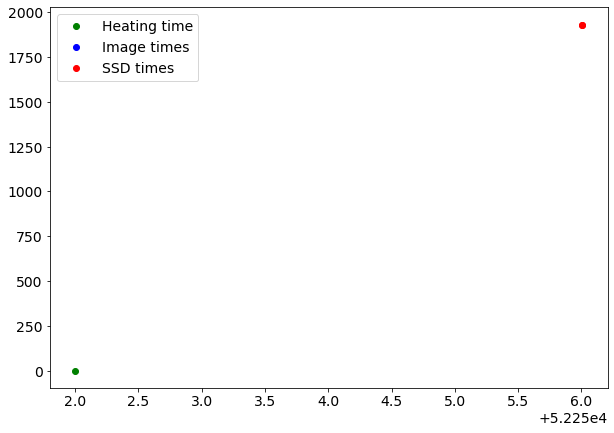

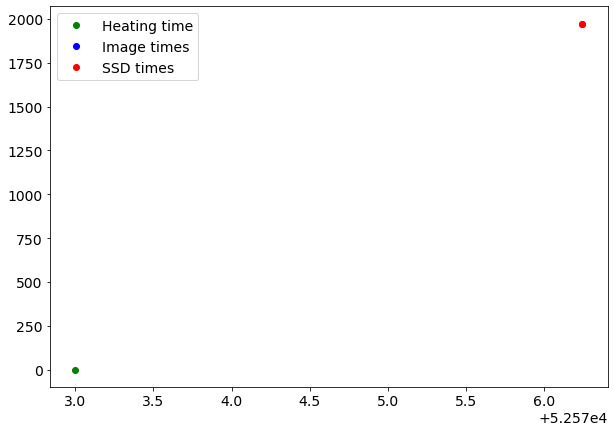

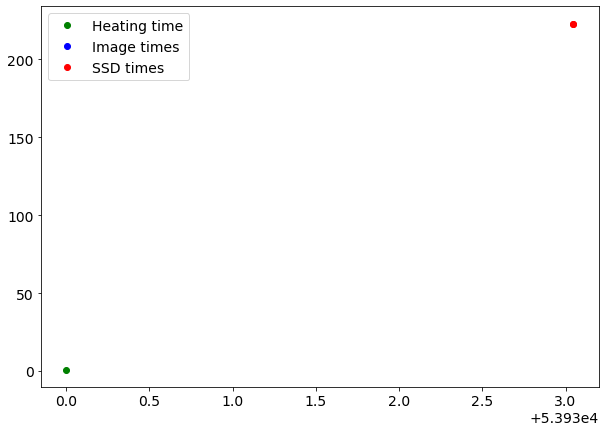

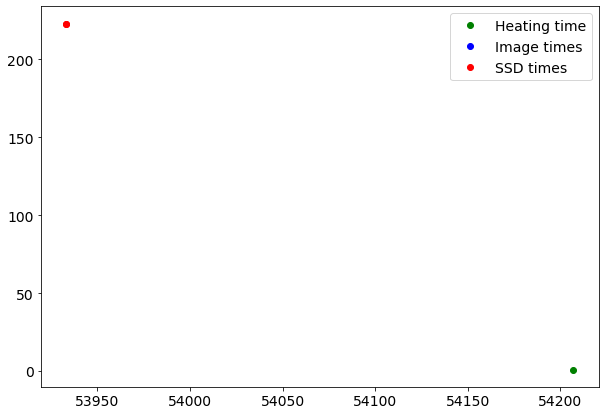

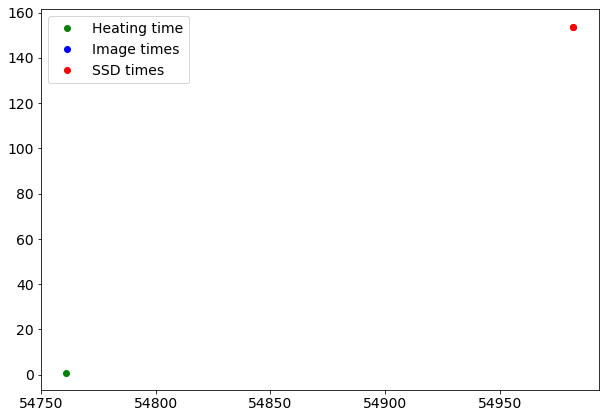

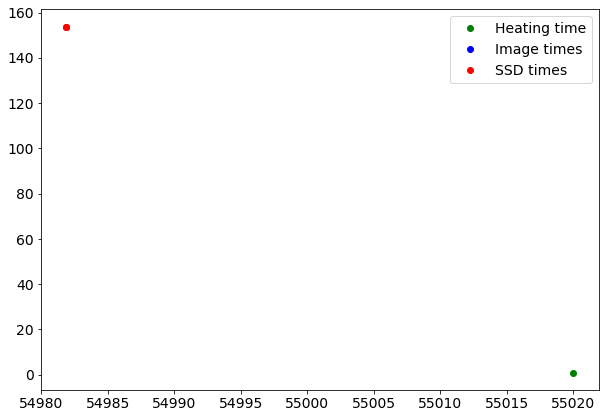

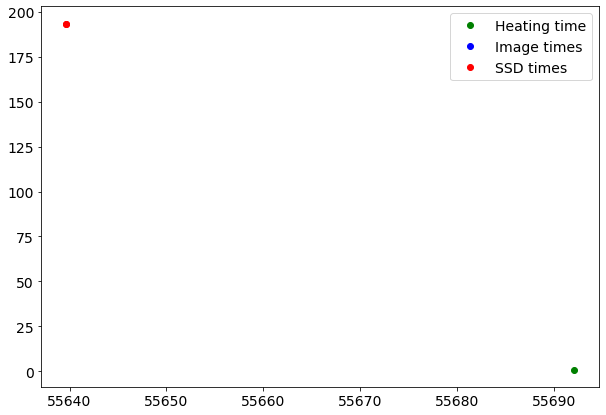

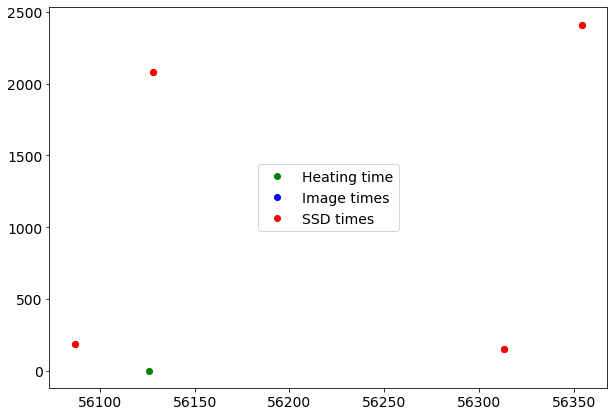

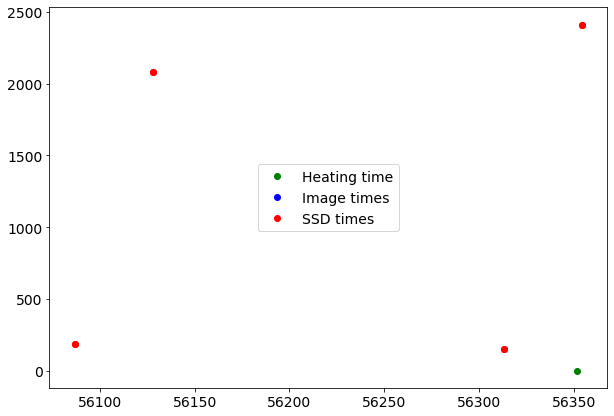

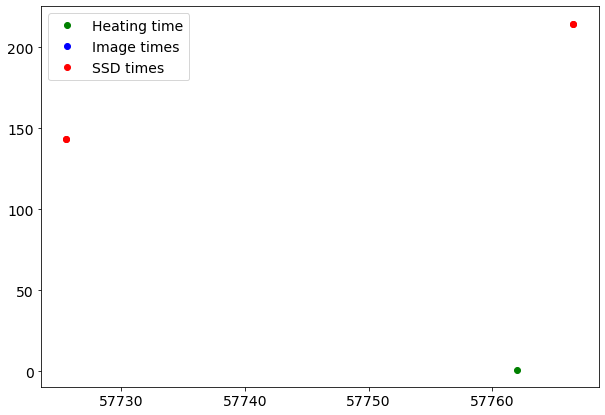

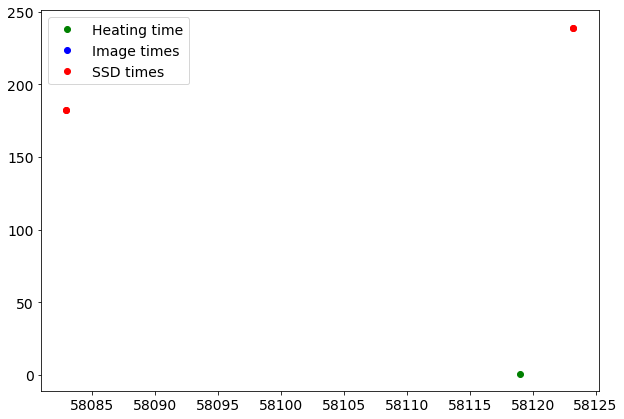

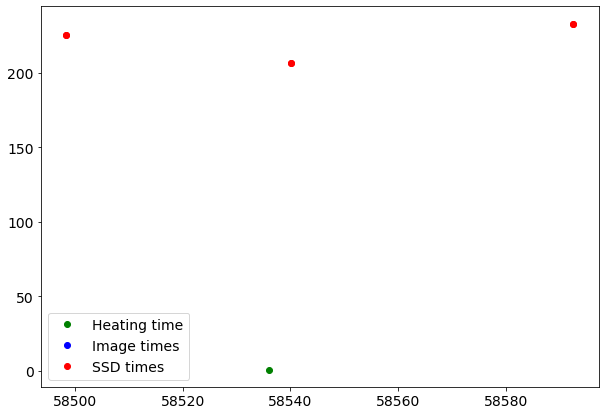

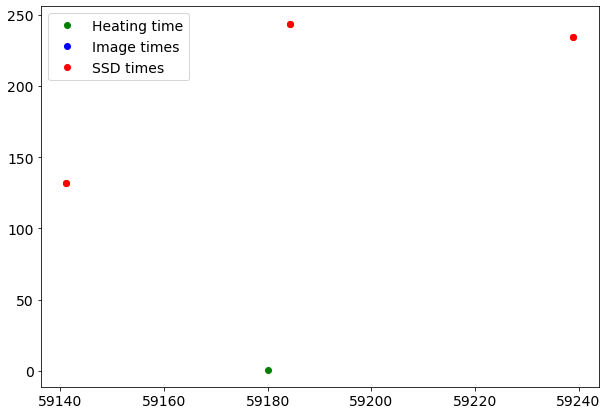

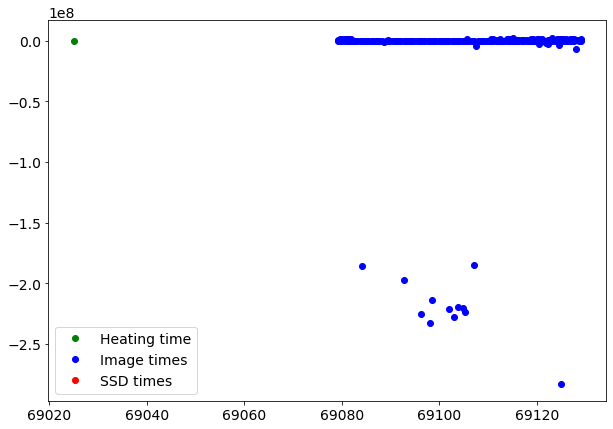

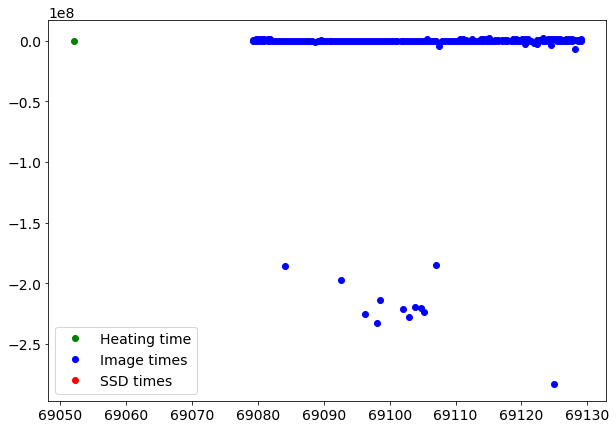

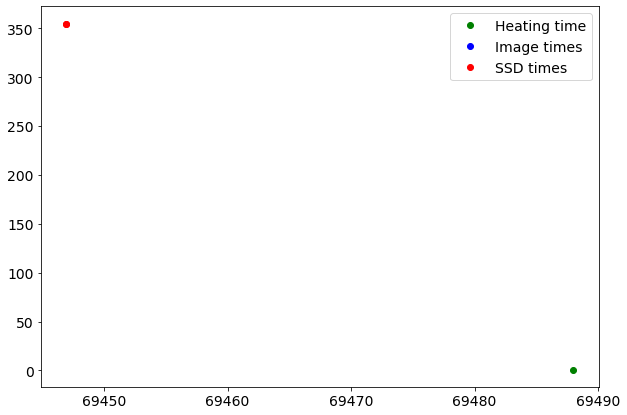

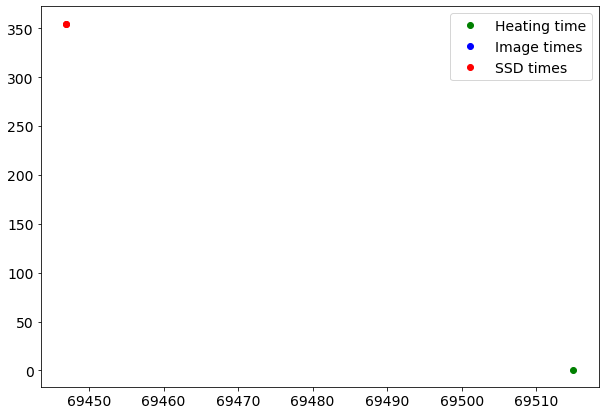

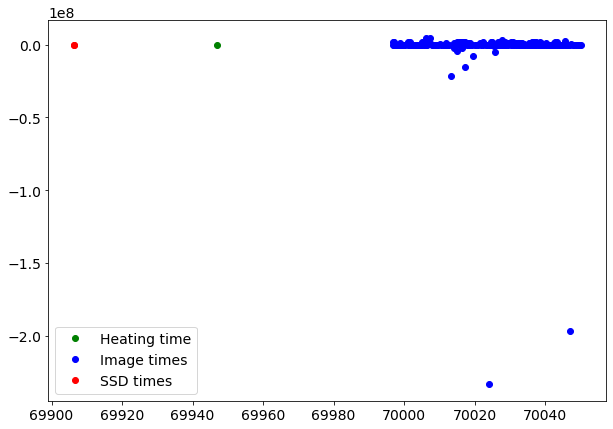

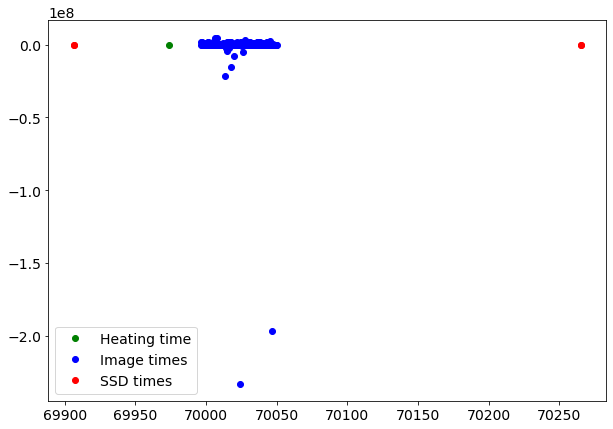

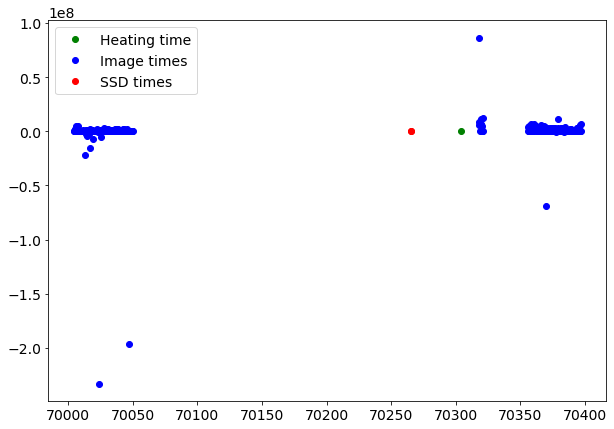

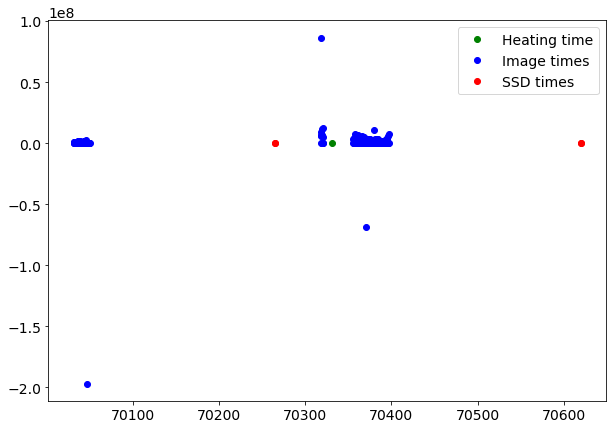

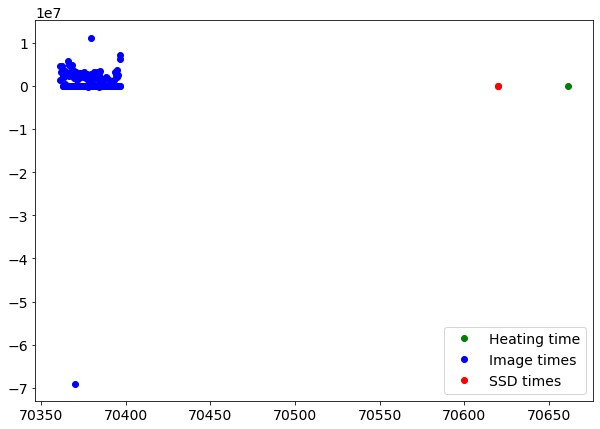

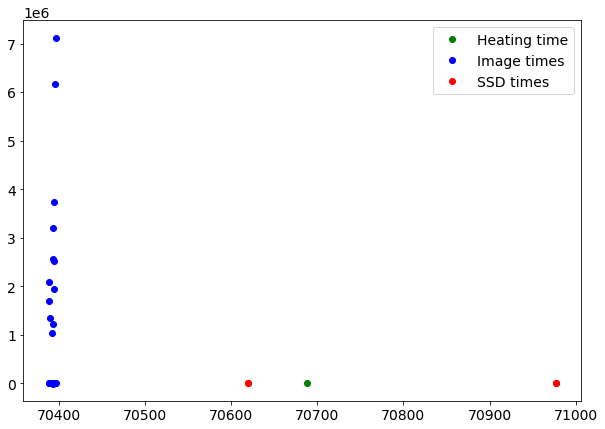

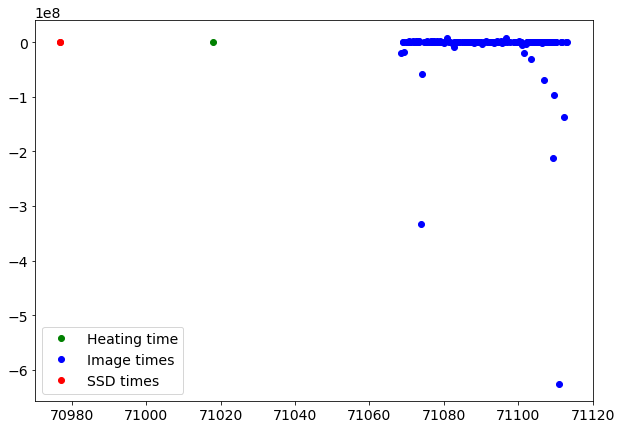

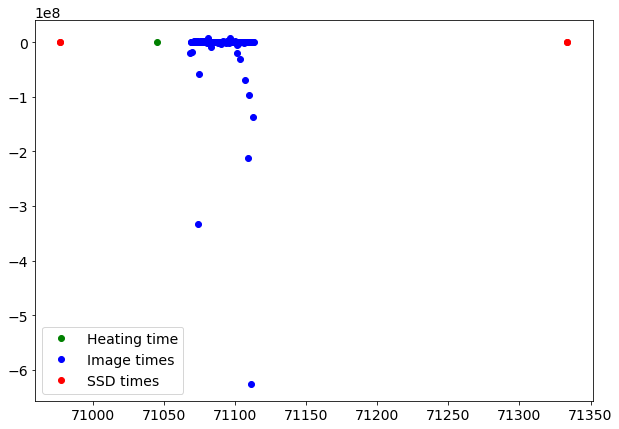

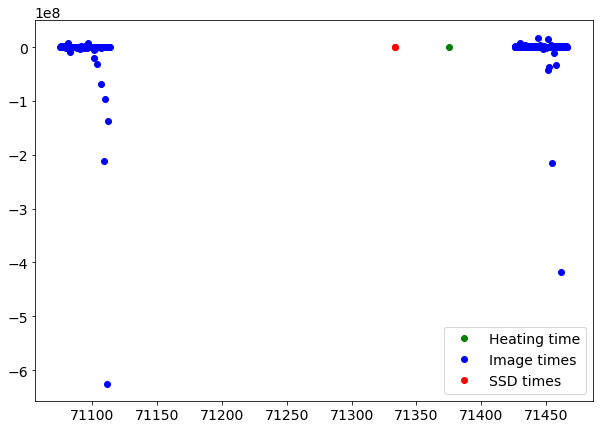

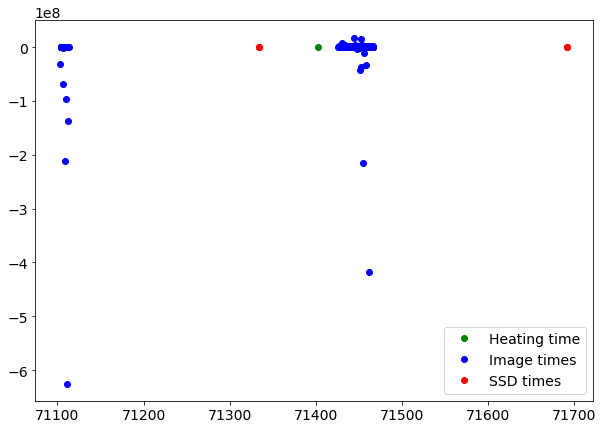

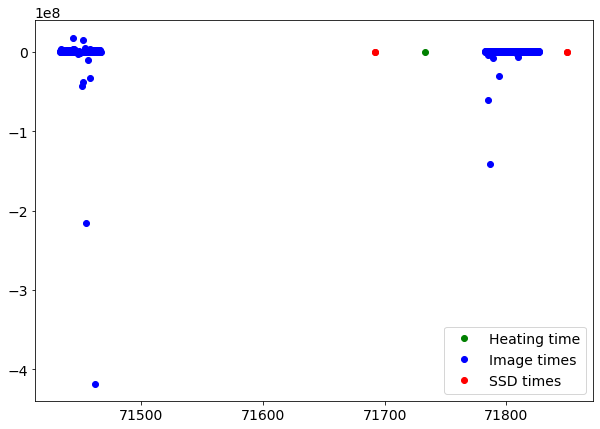

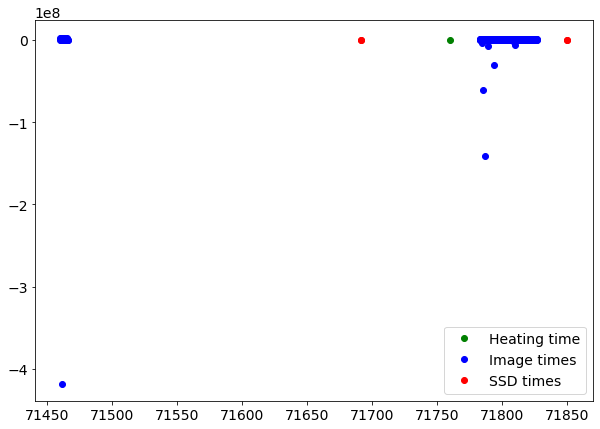

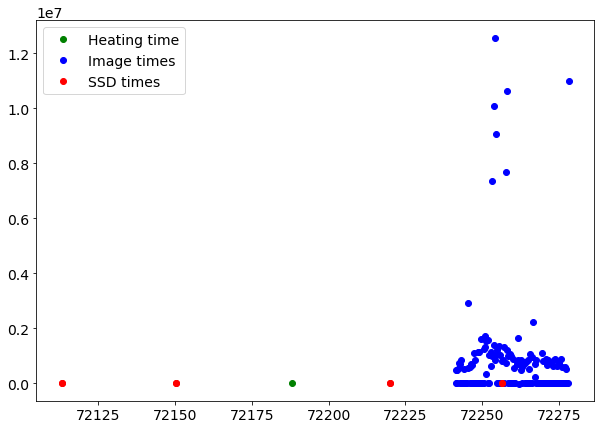

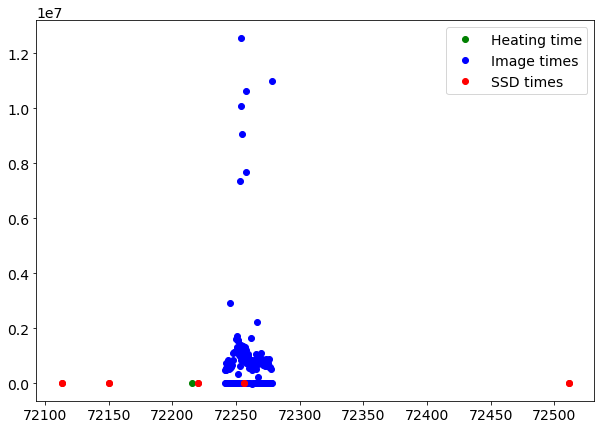

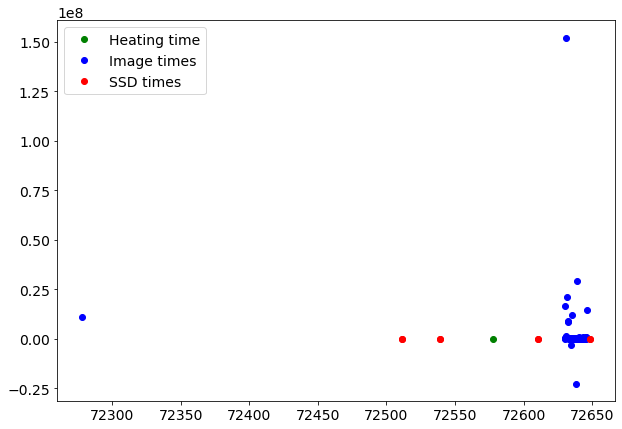

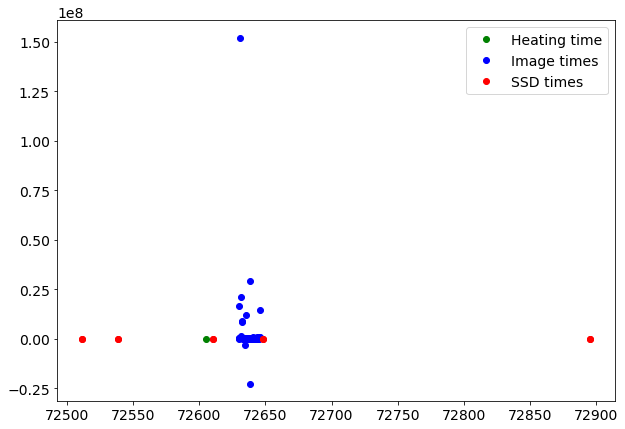

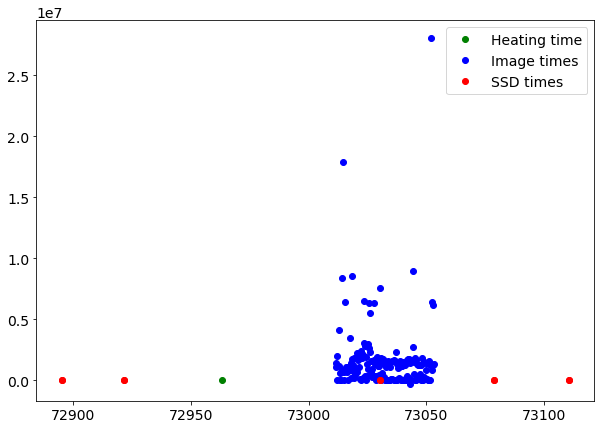

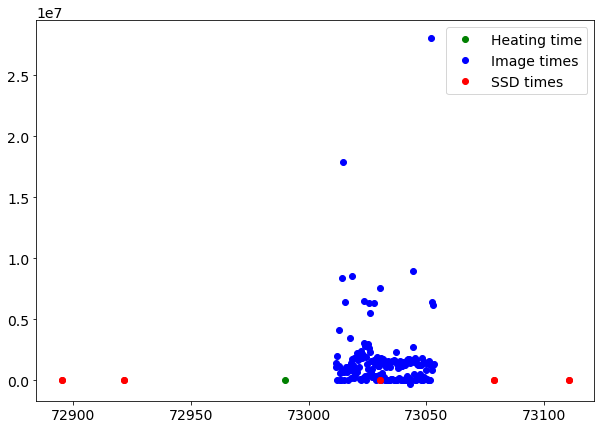

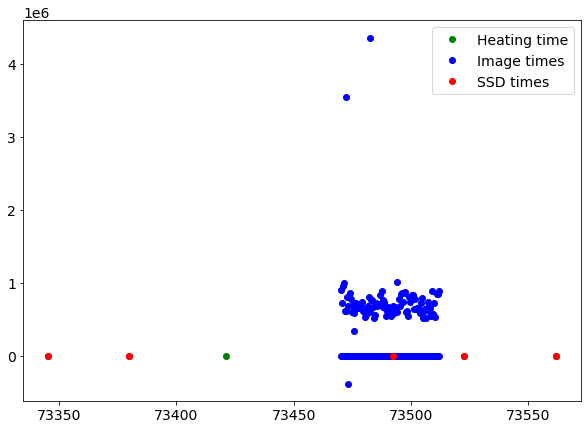

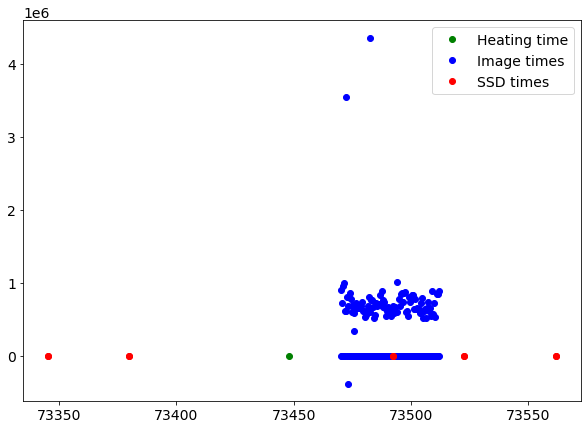

In [127]:
for t, image_df, ssd_df in zip(ht_df_18["seconds"], queried_image_dfs, queried_ssd_dfs): 

  # Heating time
  plt.plot(t, [1], "go", label="Heating time")

  # Image
  x_image = image_df["seconds"]
  y_image = image_df["A"]
  plt.plot(x_image, y_image, "bo", label="Image times")

  # SSD
  x_ssd = ssd_df["seconds"]
  y_ssd = ssd_df["pulses_peak"]
  plt.plot(x_ssd, y_ssd, "ro", label="SSD times")

  plt.legend()
  plt.show()

In [ ]:
!git status